<a href="https://colab.research.google.com/github/FrodoBaggins87/Machine_Learning/blob/main/Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Generate Toy Dataset


In [33]:
import sklearn
from sklearn.datasets import make_circles

#choose number of samples
n_samples=1000

#create circles
x,y=make_circles(n_samples,
                 noise=0.02,
                 random_state=66)

In [34]:
len(x), len(y)

(1000, 1000)

In [35]:
print(x[:5])
print(y[:5])

[[-0.72974363  0.68637738]
 [ 0.66264716 -0.44070676]
 [-0.25925316  0.77418256]
 [-0.48943149 -0.61886408]
 [ 0.08215533  1.04318507]]
[0 1 1 1 0]


In [36]:
import pandas as pd
circle_data=pd.DataFrame({"x_1":x[:,0],
                         "x_2":x[:,1],
                         "label":y})
circle_data.head()

,x_1,x_2,label
0,-0.729744,0.686377,0
1,0.662647,-0.440707,1
2,-0.259253,0.774183,1
3,-0.489431,-0.618864,1
4,0.082155,1.043185,0


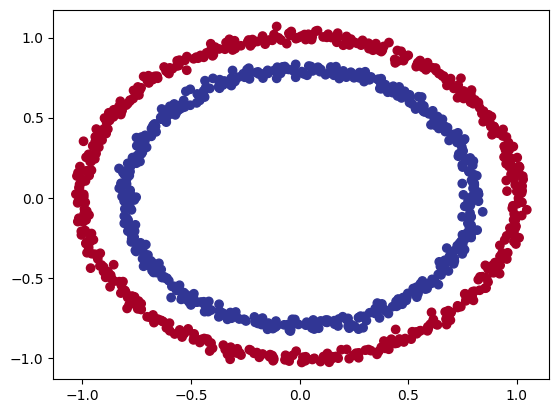

In [37]:
#Visulaizing data
import matplotlib.pyplot as plt
plt.scatter(x=x[:,0],
            y=x[:,1],
            c=y, #colour deided by the value in y
            cmap=plt.cm.RdYlBu)#cmap sets the color map based on value of y

Check input and output shapes


In [38]:
x.shape,y.shape

((1000, 2), (1000,))

In [39]:
print("sample x value", x[0])
print("sample y value", y[0])

sample x value [-0.72974363  0.68637738]
sample y value 0


Turn data into tensors


In [40]:
import torch
torch.__version__

'2.1.0+cu121'

In [41]:
type(x)

numpy.ndarray

In [42]:
#Turn into tensor
x_tensor=torch.from_numpy(x).type(torch.float)
y_tensor=torch.from_numpy(y).type(torch.float)#float will convert to float32 by default
type(x_tensor),type(y_tensor),x_tensor.dtype,y_tensor.dtype

(torch.Tensor, torch.Tensor, torch.float32, torch.float32)

In [43]:
#split into training and test dataset
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test= train_test_split(x,
                                                y,
                                                test_size=0.2) #20% of whole dataset)

In [44]:
len(x_train),len(x_test),len(y_train),len(y_test)

(800, 200, 800, 200)

Building a model


In [45]:
import torch
from torch import nn
#make device agnostic code
device= "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'